In [1]:
# Linear regression with gluon
# jupyter: https://github.com/zackchase/mxnet-the-straight-dope
# http://gluon.mxnet.io/chapter02_supervised-learning/linear-regression-gluon.html
# note had to install pip3 install mxnet==1.1.0b20180208 because mxnet version 1.0.0 does not work
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon
import sys

/usr/local/lib/python3.6/site-packages/mxnet/optimizer.py:136: UserWarning: WARNING: New optimizer mxnet.optimizer.NAG is overriding existing optimizer mxnet.optimizer.NAG
  Optimizer.opt_registry[name].__name__))


In [2]:
# set contect
data_ctx = mx.cpu()
model_ctx = mx.cpu()

#build data set
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2

X = nd.random_normal(shape=(num_examples, num_inputs))
noise = 0.01 * nd.random_normal(shape=(num_examples,))
y = real_fn(X) + noise

# load iterator

batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y),
                                      batch_size=batch_size, shuffle=True)

In [3]:
# Define the model
# http://gluon.mxnet.io/chapter02_supervised-learning/linear-regression-gluon.html#Define-the-model

net = gluon.nn.Dense(1, in_units=2)
# just as well to omit "in_units" see http://gluon.mxnet.io/chapter02_supervised-learning/linear-regression-gluon.html#Shape-inference
# For example: net = gluon.nn.Dense(1)


# TODO update mxnet to stable when issue mentioned in links is resolved
# https://stackoverflow.com/questions/47755934/why-does-the-weight-matrix-of-the-mxnet-gluon-nn-dense-object-has-no-shape
# https://github.com/apache/incubator-mxnet/commit/1852e2f47d68bb4c2373a359a2a8671b59cd14e5
# https://github.com/apache/incubator-mxnet/commit/d77d937eaf7e13a30320368d316516bd9da52ca5
print(net.weight)
print(net.bias)

Parameter dense0_weight (shape=(1, 2), dtype=<class 'numpy.float32'>)
Parameter dense0_bias (shape=(1,), dtype=<class 'numpy.float32'>)


In [4]:
net.collect_params()

dense0_ (
  Parameter dense0_weight (shape=(1, 2), dtype=<class 'numpy.float32'>)
  Parameter dense0_bias (shape=(1,), dtype=<class 'numpy.float32'>)
)

In [5]:
print(type(net.collect_params()))
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

<class 'mxnet.gluon.parameter.ParameterDict'>


In [6]:
# pass some data
example_data = nd.array([[4,7]])
net(example_data)


[[ 7.50436497]]
<NDArray 1x1 @cpu(0)>

In [7]:
print(net.weight.data())
print(net.bias.data())


[[ 0.9344402  0.5380863]]
<NDArray 1x2 @cpu(0)>

[ 0.]
<NDArray 1 @cpu(0)>


In [8]:
# define loss and optimizer
# http://gluon.mxnet.io/chapter02_supervised-learning/linear-regression-gluon.html#Define-loss
#Loss
square_loss = gluon.loss.L2Loss()
# Optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})


In [9]:
# runn the training
epochs = 15
loss_sequence = []
num_batches = num_examples / batch_size

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
#         print(data)
#         print(data.shape)
#         print(label.shape);
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.mean(loss).asscalar()
    print("Epoch %s, loss: %s" % (e, cumulative_loss / num_examples))
    loss_sequence.append(cumulative_loss)

Epoch 0, loss: 3.44441568905
Epoch 1, loss: 2.06030158314
Epoch 2, loss: 1.23239529221
Epoch 3, loss: 0.737179080865
Epoch 4, loss: 0.440960391181
Epoch 5, loss: 0.263774137636
Epoch 6, loss: 0.157787265977
Epoch 7, loss: 0.0943901389235
Epoch 8, loss: 0.0564677172326
Epoch 9, loss: 0.0337827913052
Epoch 10, loss: 0.020213217145
Epoch 11, loss: 0.0120963067396
Epoch 12, loss: 0.00724097125954
Epoch 13, loss: 0.00433690361225
Epoch 14, loss: 0.00259945482334


Text(0,0.5,'average loss')

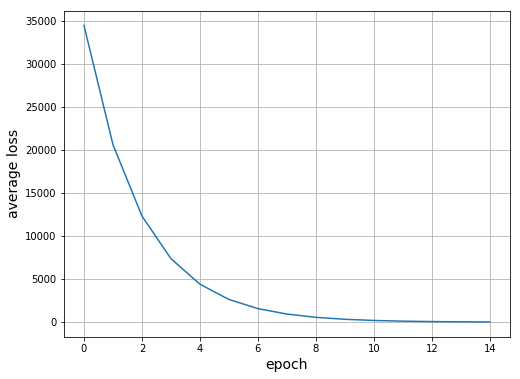

In [10]:
#plot learning 
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

In [11]:
# Checking Learned model Parameters
# http://gluon.mxnet.io/chapter02_supervised-learning/linear-regression-gluon.html#Getting-the-learned-model-parameters

# def real_fn(X):
#     return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2


params = net.collect_params() # this returns a ParameterDict

print('The type of "params" is a ',type(params))

# A ParameterDict is a dictionary of Parameter class objects
# therefore, here is how we can read off the parameters from it.

for param in params.values():
    print(param.name,param.data())

The type of "params" is a  <class 'mxnet.gluon.parameter.ParameterDict'>
dense0_weight 
[[ 1.97578359 -3.31767774]]
<NDArray 1x2 @cpu(0)>
dense0_bias 
[ 4.1102643]
<NDArray 1 @cpu(0)>


In [12]:
example_data = nd.array([
    [0.03629481, -0.49024421],
    [-0.95017916,  0.03751944]
])
print(net(example_data))


[[ 5.80844736]
 [ 2.10843849]]
<NDArray 2x1 @cpu(0)>
